In [83]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor, plot_importance
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
import sys
sys.path.insert(0, '../data_prep')
from sqlite_utils import select_statement_to_df, df_to_table, table_to_df
import shap

pd.options.display.float_format = '{:.2f}'.format
pd.set_option('display.max_rows', 500, 'display.max_columns', 200)

In [84]:
all_features_query = """

WITH BASE_TABLE AS (
    
      SELECT
      
        a.FILM_ID
        ,c.FILM_TITLE
        ,d.FILM_GENRE
        ,e.FILM_RATING
        ,f.FILM_RATING_SCALED
        ,CASE WHEN f.FILM_RATING_SCALED IS NOT NULL THEN 1 ELSE 0 END AS RATED
      
      FROM ALL_FILMS a
      LEFT JOIN CONTENT_TYPE b
      ON a.FILM_ID = b.FILM_ID
      LEFT JOIN FILM_TITLE c
      ON a.FILM_ID = c.FILM_ID
      LEFT JOIN FILM_GENRE d
      ON a.FILM_ID = d.FILM_ID
      LEFT JOIN FILM_LETTERBOXD_STATS e
      ON a.FILM_ID = e.FILM_ID
      LEFT JOIN PERSONAL_RATING f
      ON a.FILM_ID = f.FILM_ID
      
      WHERE CONTENT_TYPE = 'movie'
      
    )
   
    SELECT

      a.FILM_ID
      ,b.FILM_TITLE
      ,c.FILM_WATCH_COUNT
      ,g.TOP_250_POSITION AS FILM_TOP_250
      ,c.FILM_RATING
      ,COALESCE(1.0*c.FILM_LIKES_COUNT/c.FILM_WATCH_COUNT, 0.0) AS LIKES_PER_WATCH
      ,COALESCE(1.0*c.FILM_FAN_COUNT/c.FILM_WATCH_COUNT, 0.0) AS FANS_PER_WATCH
      ,d.FILM_RUNTIME
      ,f.FILM_YEAR
      ,e.ALL_FILM_GENRES
    
    FROM ALL_FEATURE_FILMS a
    LEFT JOIN FILM_TITLE b
    ON a.FILM_ID = b.FILM_ID
    LEFT JOIN FILM_LETTERBOXD_STATS c
    ON a.FILM_ID = c.FILM_ID
    LEFT JOIN FILM_RUNTIME d
    ON a.FILM_ID = d.FILM_ID
    LEFT JOIN FILM_GENRE e
    ON a.FILM_ID = e.FILM_ID
    LEFT JOIN FILM_YEAR f
    ON a.FILM_ID = f.FILM_ID
    LEFT JOIN FILM_LETTERBOXD_TOP_250 g
    ON a.FILM_ID = g.FILM_ID

"""

keyword_query = """

WITH BASE_TABLE AS (
    
    SELECT
    
        a.FILM_ID
        ,c.FILM_TITLE
        ,d.KEYWORD
        ,d.KEYWORD_ID
        ,e.FILM_RATING
        ,f.FILM_RATING_SCALED
        ,CASE WHEN f.FILM_RATING_SCALED IS NOT NULL THEN 1 ELSE 0 END AS RATED
    
    FROM ALL_FEATURE_FILMS a
    LEFT JOIN CONTENT_TYPE b
    ON a.FILM_ID = b.FILM_ID
    LEFT JOIN FILM_TITLE c
    ON a.FILM_ID = c.FILM_ID
    LEFT JOIN FILM_KEYWORDS d
    ON a.FILM_ID = d.FILM_ID
    LEFT JOIN FILM_LETTERBOXD_STATS e
    ON a.FILM_ID = e.FILM_ID
    LEFT JOIN PERSONAL_RATING f
    ON a.FILM_ID = f.FILM_ID
    
    WHERE b.CONTENT_TYPE = 'movie'
    
    )
    
, SCORE_TABLE AS (

    SELECT

    KEYWORD_ID
    ,KEYWORD
    ,AVG(FILM_RATING) AS MEAN_RATING
    ,AVG(FILM_RATING_SCALED) AS MY_MEAN_RATING
    ,AVG(FILM_RATING_SCALED) - AVG(FILM_RATING) AS MY_VARIANCE
    ,((AVG(FILM_RATING_SCALED) - AVG(FILM_RATING)) * ((SUM(RATED)+0.0)/COUNT(*))) AS VARIANCE_SCORE
    ,COUNT(*) AS KEYWORD_COUNT
    ,SUM(RATED) AS MY_RATING_COUNT
    ,(SUM(RATED)+0.0)/COUNT(*) AS SCALER
    
    FROM BASE_TABLE
    
    GROUP BY KEYWORD
    
    HAVING KEYWORD_COUNT >= 30
    AND SCALER >= 0.2
    AND MY_RATING_COUNT >= 3
    --ORDER BY MEAN_RATING DESC
    --ORDER BY KEYWORD_COUNT DESC
    --ORDER BY MY_VARIANCE DESC
    --ORDER BY VARIANCE_SCORE DESC
    --ORDER BY MY_MEAN_RATING DESC
    --ORDER BY VARIANCE_SCORE DESC
)

SELECT
    a.FILM_ID
    ,a.KEYWORD_ID
    ,b.KEYWORD
    
FROM FILM_KEYWORDS a
LEFT JOIN SCORE_TABLE b
ON a.KEYWORD_ID = b.KEYWORD_ID

WHERE b.KEYWORD_ID IS NOT NULL

"""

my_rating_query = """

    SELECT
         FILM_ID
        ,FILM_RATING_SCALED
    FROM PERSONAL_RATING

"""

director_rating_query = """

WITH BASE_TABLE AS (

    SELECT

        a.FILM_ID
        ,d.FILM_TITLE
        ,b.PERSON_ID
        ,e.PERSON_NAME AS DIRECTOR_NAME
        ,CASE WHEN c.FILM_ID IS NULL THEN 0 ELSE 1 END AS WATCHED
        ,f.FILM_RATING_SCALED
        ,CASE WHEN f.FILM_RATING_SCALED IS NULL THEN 0 ELSE 1 END AS RATED

    FROM ALL_FEATURE_FILMS a

    LEFT JOIN FILM_CREW b
    ON a.FILM_ID = b.FILM_ID

    LEFT JOIN WATCHED c
    ON a.FILM_ID = c.FILM_ID

    LEFT JOIN FILM_TITLE d
    ON a.FILM_ID = d.FILM_ID

    LEFT JOIN PERSON_INFO e
    ON b.PERSON_ID = e.PERSON_ID

    LEFT JOIN PERSONAL_RATING f
    ON a.FILM_ID = f.FILM_ID

    WHERE b.JOB = 'Director'
        
    )
      
, DIRECTOR_RATINGS AS (

	SELECT
      
       PERSON_ID
	  ,DIRECTOR_NAME
      ,COUNT(*) AS TOTAL_FILMS
      ,SUM(WATCHED) AS FILMS_WATCHED
      ,AVG(WATCHED) AS PERCENT_WATCHED
      ,AVG(FILM_RATING_SCALED) AS MEAN_RATING
      ,SUM(RATED) AS FILMS_RATED
      ,AVG(RATED) AS PERCENT_RATED
      
    FROM BASE_TABLE
    
    GROUP BY PERSON_ID, DIRECTOR_NAME

    HAVING TOTAL_FILMS >= 3
    AND FILMS_WATCHED > 1
    AND FILMS_RATED > 1
    AND MEAN_RATING NOT NULL
    AND PERCENT_RATED >= .2
    
 	)
, DIRECTOR_WATCH_STATS AS (

	SELECT
      
       PERSON_ID
	  ,DIRECTOR_NAME
      ,COUNT(*) AS TOTAL_FILMS
      ,AVG(WATCHED) AS PERCENT_WATCHED
      
    FROM BASE_TABLE
    
    GROUP BY PERSON_ID, DIRECTOR_NAME
    
 	)

, MEAN_RATING AS ( SELECT AVG(MEAN_RATING)AS MEAN_TOTAL_RATING FROM DIRECTOR_RATINGS )

, FILM_DIRECTOR_LEVEL AS (

	SELECT
		
		 a.FILM_ID
		,a.FILM_TITLE
		,a.PERSON_ID
		,a.DIRECTOR_NAME
		,COALESCE(b.MEAN_RATING, (SELECT 0.8*MEAN_TOTAL_RATING FROM MEAN_RATING)) AS DIRECTOR_MEAN_RATING
		,COALESCE(c.TOTAL_FILMS, 0) AS DIRECTOR_TOTAL_FILMS
		,COALESCE(c.PERCENT_WATCHED, 0) AS DIRECTOR_PERCENT_WATCHED
		
	 FROM BASE_TABLE a
	 LEFT JOIN DIRECTOR_RATINGS b 
	 ON a.PERSON_ID = b.PERSON_ID
	 LEFT JOIN DIRECTOR_WATCH_STATS c
	 ON a.PERSON_ID = c.PERSON_ID
	 
	 )
	 
SELECT
	
	 FILM_ID
	,AVG(DIRECTOR_MEAN_RATING) AS DIRECTOR_MEAN_RATING
	,AVG(DIRECTOR_TOTAL_FILMS) AS DIRECTOR_TOTAL_FILMS
	,AVG(DIRECTOR_PERCENT_WATCHED) AS DIRECTOR_PERCENT_WATCHED

FROM FILM_DIRECTOR_LEVEL

GROUP BY FILM_ID, FILM_TITLE

"""

top_actor_film_level_query = """

WITH BASE_TABLE AS (

    SELECT

        a.FILM_ID
        ,d.FILM_TITLE
        ,b.PERSON_ID
        ,e.PERSON_NAME AS ACTOR_NAME
        ,CASE WHEN c.FILM_ID IS NULL THEN 0 ELSE 1 END AS WATCHED
        ,CASE WHEN f.FILM_RATING_SCALED IS NOT NULL THEN 1 ELSE 0 END AS RATED
        ,f.FILM_RATING_SCALED

    FROM ALL_FEATURE_FILMS a
    
    LEFT JOIN FILM_CAST b
    ON a.FILM_ID = b.FILM_ID
    
    LEFT JOIN WATCHED c
    ON a.FILM_ID = c.FILM_ID
    
    LEFT JOIN FILM_TITLE d
    ON a.FILM_ID = d.FILM_ID

    LEFT JOIN PERSON_INFO e
    ON b.PERSON_ID = e.PERSON_ID

    LEFT JOIN PERSONAL_RATING f
    ON a.FILM_ID = f.FILM_ID

    WHERE e.PERSON_NAME IS NOT NULL
    
    )
    
, ACTOR_TABLE AS (

    SELECT

    PERSON_ID
    ,SUM(WATCHED) AS TOTAL_WATCHED
    
    FROM BASE_TABLE
    
    GROUP BY PERSON_ID
    
    HAVING TOTAL_WATCHED >= 20
)

SELECT
    
     a.FILM_ID
    ,a.PERSON_ID
    ,a.ACTOR_NAME
    ,1 AS ACTOR_IN_FILM
    
FROM BASE_TABLE a
INNER JOIN ACTOR_TABLE b
ON a.PERSON_ID = b.PERSON_ID

"""

def scale_col(df, column, suffix='', a=0, b=1):
    col_min = df[column].min()
    col_max = df[column].max()
    col_range = (col_max - col_min)
    df[column+suffix] = ((df[column] - col_min) / col_range) * (b - a) + a
    return df


In [85]:
def get_valid_cols(film_id, shap_df, min_shap_val=0.001):
    filmid_shap_df = shap_df[shap_df['FILM_ID']==film_id].reset_index(drop=True)
    valid_cols = []
    for col in filmid_shap_df.columns:
        shap_val = filmid_shap_df[col][0]
        if isinstance(shap_val, str):
            col_valid = False
        elif np.isnan(shap_val):
            col_valid = False
        elif abs(shap_val) < min_shap_val:
            col_valid = False
        elif col == 'BASE_VALUE':
            col_valid = True
        else:
            col_valid = True
        if col_valid:
            valid_cols.append(col)
    return valid_cols

def create_dual_df(film_id, pred_df, shap_df, valid_cols):
    film_title = pred_df[pred_df['FILM_ID']==film_id]['FILM_TITLE'].values[0]
    dual_df = pd.concat([pred_df[pred_df['FILM_ID']==film_id], shap_df[shap_df['FILM_ID']==film_id]])
    dual_df['FILM_TITLE'] = dual_df['FILM_TITLE'].fillna(film_title)
    dual_df['ALGO_SCORE'] = dual_df['ALGO_SCORE'].fillna(dual_df['ALGO_SCORE'].max())
    dual_df = dual_df[valid_cols]
    dual_df.insert(2, 'INFO', ['FEATURE_VALUE', 'SHAP_VALUE'])
    dual_df = dual_df.reset_index(drop=True)
    return dual_df

def return_comparison_df(film_ids, min_shap_val=0.001, decimal_places=3):
    pred_df = table_to_df(table_name='FILM_ALGO_SCORE')
    shap_df = table_to_df(table_name='FILM_SHAP_VALUES')
    valid_cols = [get_valid_cols(x, shap_df, min_shap_val=min_shap_val) for x in film_ids]
    valid_cols = list(set([col for valid_col_list in valid_cols for col in valid_col_list]))
    valid_cols = ['FILM_ID', 'FILM_TITLE', 'ALGO_SCORE'] + valid_cols
    valid_cols = [x for x in pred_df.columns if x in valid_cols]
    valid_cols.append('BASE_VALUE')
    all_dfs = []
    for n, film_id in enumerate(film_ids):
        dual_df = create_dual_df(film_id, pred_df, shap_df, valid_cols)
        melted_df = pd.melt(dual_df, id_vars=['FILM_ID', 'FILM_TITLE', 'INFO'])
        pivoted_df = melted_df.drop('FILM_ID', axis=1).pivot(index='variable', columns=['FILM_TITLE', 'INFO'], values='value').reset_index()
        pivoted_df.columns = [' '.join(col) for col in pivoted_df.columns]
        if n > 0:
            pivoted_df = pivoted_df.drop('variable ', axis=1)
        all_dfs.append(pivoted_df)
    comparison_df = pd.concat(all_dfs, axis=1)
    if len(film_ids) > 1:
        comparison_df['VAR'] = comparison_df[comparison_df.columns[4]] - comparison_df[comparison_df.columns[2]]
        comparison_df['ABS_VAR'] = comparison_df['VAR'].abs()
        comparison_df = comparison_df.sort_values('ABS_VAR', ascending=False)
    else:
        comparison_df = comparison_df.sort_values(comparison_df.columns[2], ascending=False)
    return comparison_df.round(decimal_places)

def min_max_scale(arr):
    arr = np.array(arr, dtype=np.float64)
    return (arr - np.min(arr)) / (np.max(arr) - np.min(arr))

In [86]:
eligible_watchlist_df = select_statement_to_df(all_features_query)
director_rating_df = select_statement_to_df(director_rating_query)
eligible_watchlist_df = eligible_watchlist_df.merge(director_rating_df, how='left', on='FILM_ID')
eligible_watchlist_df = pd.concat([eligible_watchlist_df, eligible_watchlist_df['ALL_FILM_GENRES'].str.get_dummies(sep='/')], axis=1).drop('ALL_FILM_GENRES', axis=1)
keyword_df = select_statement_to_df(keyword_query)
keyword_df['COUNT'] = 1
keyword_df_wide = pd.pivot_table(keyword_df, values='COUNT', index=['FILM_ID'], columns=['KEYWORD']).fillna(0).reset_index()
eligible_watchlist_df = eligible_watchlist_df.merge(keyword_df_wide, how='left', on='FILM_ID')
top_actor_film_level_df = select_statement_to_df(top_actor_film_level_query)
actor_lookup_df = top_actor_film_level_df.groupby(['PERSON_ID', 'ACTOR_NAME']).count().reset_index()
actor_lookup_dict = {id:name for id, name in zip(actor_lookup_df['PERSON_ID'], actor_lookup_df['ACTOR_NAME'])}
top_actor_film_level_df_wide = pd.pivot_table(top_actor_film_level_df, values='ACTOR_IN_FILM', index=['FILM_ID'], columns='PERSON_ID').fillna(0)
top_actor_film_level_df_wide.columns = [actor_lookup_dict.get(x, x) for x in top_actor_film_level_df_wide.columns]
eligible_watchlist_df['FILM_TOP_250'] = eligible_watchlist_df['FILM_TOP_250'].fillna(266)
eligible_watchlist_df.insert(4, 'FILM_IS_TOP_250', np.where(eligible_watchlist_df['FILM_TOP_250']<=250, 1, 0))
eligible_watchlist_df = eligible_watchlist_df.merge(top_actor_film_level_df_wide, how='left', on='FILM_ID').fillna(0)
eligible_watchlist_df['FILM_RATING'] = eligible_watchlist_df['FILM_RATING'].fillna(2.0)
eligible_watchlist_df = eligible_watchlist_df.fillna(0)
my_rating_df = select_statement_to_df(my_rating_query)
rating_features_df = eligible_watchlist_df.merge(my_rating_df, how='left', on='FILM_ID')
rating_features_df['I_VS_LB'] = rating_features_df['FILM_RATING_SCALED'] - rating_features_df['FILM_RATING']
rated_features = rating_features_df[rating_features_df['FILM_RATING_SCALED'].notnull()].reset_index(drop=True)
unrated_features = rating_features_df[rating_features_df['FILM_RATING_SCALED'].isnull()].reset_index(drop=True)
rating_features_df.head()

,FILM_ID,FILM_TITLE,FILM_WATCH_COUNT,FILM_TOP_250,FILM_IS_TOP_250,FILM_RATING,LIKES_PER_WATCH,FANS_PER_WATCH,FILM_RUNTIME,FILM_YEAR,DIRECTOR_MEAN_RATING,DIRECTOR_TOTAL_FILMS,DIRECTOR_PERCENT_WATCHED,action,adventure,animation,comedy,crime,drama,family,fantasy,history,horror,music,mystery,none,romance,science-fiction,thriller,tv-movie,war,western,2000s,adventurer,aftercreditsstinger,aggressive,alien,alien invasion,alien life-form,amused,amusement park,android,animal horror,antagonistic,anthropomorphism,anti hero,anxious,apocalypse,archaeologist,army,artificial intelligence (a.i.),astronaut,audacious,awestruck,babysitter,based on comic,basement,bible,black magic,body horror,bold,brutality,callous,car race,cautionary,celebratory,chainsaw,church,clown,complex,computer,corpse,creature,cruelty,cult,cyberpunk,cyborg,cynical,death game,decapitation,demon,demonic possession,desperate,disturbed,doppelgänger,dracula,dramatic,duel,duringcreditsstinger,dystopia,end of the world,evil,ex-cop,excited,existentialism,exorcism,fantasy world,fate,female villain,flying,...,self sacrifice,serial killer,series of murders,shocking,shotgun,sign languages,slasher,sociopath,space,space marine,space opera,space travel,spacecraft,spin off,steampunk,stop motion,summer camp,superhero,supernatural horror,supernatural power,surrealism,survival horror,suspenseful,telekinesis,telepathy,time loop,time travel,tragic,transformation,treasure hunt,undead,urban legend,urban setting,victim,video nasty,villain,violence,virtual reality,virus,voodoo,voyeurism,whimsical,whodunit,winter,witch,witchcraft,witty,wizard,woods,zombie,zombie apocalypse,Harrison Ford,Tom Hanks,Bruce Willis,Gary Oldman,Johnny Depp,Cate Blanchett,Christopher Lee,Jake Gyllenhaal,Brad Pitt,Robert De Niro,Tom Cruise,Steve Buscemi,Owen Wilson,John Goodman,Scarlett Johansson,Bill Murray,Matt Damon,Brendan Gleeson,Samuel L. Jackson,Nicolas Cage,Laurence Fishburne,Tilda Swinton,Liam Neeson,Christopher Walken,John Hurt,Willem Dafoe,Ralph Fiennes,Hugh Jackman,Stan Lee,John Ratzenberger,Jamie Lee Curtis,Elizabeth Banks,David Thewlis,Vin Diesel,Toby Jones,Frank Welker,Chris Evans,Josh Brolin,Michael Fassbender,Idris Elba,J.K. Simmons,Jack Angel,Alan Tudyk,Channing Tatum,Thomas Rosales Jr.,Mickie McGowan,Sherry Lynn,FILM_RATING_SCALED,I_VS_LB
0,f_01ZLI,Jumanji,1244166,266.00,0,3.63,0.19,0.00,104.00,1995,3.22,11.00,0.36,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2.65,-0.98
1,f_01UTC,Fatal Attraction,137260,266.00,0,3.46,0.17,0.00,119.00,1987,2.81,9.00,0.22,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.

In [87]:
from sklearn.model_selection import train_test_split

test_ratio = 0.05

# This first step splits into (train|dev) & test
df, df_test = train_test_split(rated_features, test_size=test_ratio, random_state=66)

print('df has {} rows and df_test has {} rows'.format(len(df), len(df_test)))
print(df_test['FILM_TITLE'].sample(10).values)

df has 1402 rows and df_test has 74 rows
['Where the Devil Roams' 'AquaSlash' 'Rogue One: A Star Wars Story'
 'Prison' 'Juno' 'The Final Destination' 'Glen or Glenda' 'Fantastic Four'
 'The Guest' 'Infinity Pool']


In [88]:
low_percentile = np.percentile(df['I_VS_LB'], 5)
high_percentile = np.percentile(df['I_VS_LB'], 95)

# Apply Winsorization (capping)
df['I_VS_LB'] = np.clip(df['I_VS_LB'], low_percentile, high_percentile)

print(f"Clipped I_VS_LB at {low_percentile:.2f} and {high_percentile:.2f}")

Clipped I_VS_LB at -1.15 and 1.05


<AxesSubplot:xlabel='I_VS_LB', ylabel='Count'>

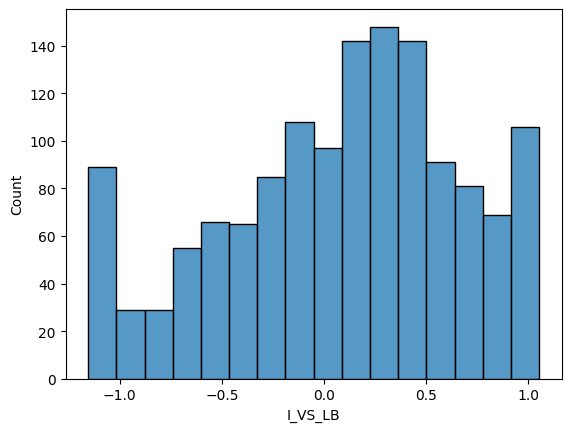

In [89]:
sns.histplot(df['I_VS_LB'])

0.4648576278743738

0.2529272943955966

,y_truth,y_predict,error,absolute_error,squared_error,percent_error,absolute_percent_error
count,74.00,74.00,74.00,74.00,74.00,74.00,74.00
mean,0.17,0.12,0.05,0.47,0.32,2.52,3.36
std,0.66,0.45,0.56,0.31,0.41,16.53,16.38
min,-1.77,-1.02,-1.50,0.01,0.00,-11.17,0.02
25%,-0.23,-0.20,-0.36,0.29,0.09,-0.02,0.57
50%,0.28,0.13,0.09,0.42,0.18,0.63,0.82
75%,0.60,0.39,0.46,0.60,0.36,1.12,1.48
max,1.74,1.09,1.07,1.50,2.25,141.38,141.38


C:\Users\tom\AppData\Local\Temp\ipykernel_59956\1744794294.py:36: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  display(sns.distplot(compare_preds_df[error_plot]))


<AxesSubplot:xlabel='error', ylabel='Density'>

,FILM_TITLE,y_truth,y_predict,error,absolute_error,squared_error,percent_error,absolute_percent_error
873,Glen or Glenda,-1.77,-0.27,-1.50,1.50,2.25,0.85,0.85
741,Prison,-1.50,-0.09,-1.41,1.41,1.98,0.94,0.94
411,Jason Goes to Hell: The Final Friday,1.74,0.67,1.07,1.07,1.14,0.61,0.61
329,Seed of Chucky,1.03,-0.01,1.04,1.04,1.09,1.01,1.01
200,Anomalisa,0.67,-0.32,0.99,0.99,0.98,1.48,1.48
796,Blade II,1.35,0.36,0.99,0.99,0.98,0.73,0.73
774,Turning Red,0.42,-0.56,0.98,0.98,0.95,2.32,2.32
1351,Fantastic Four,-0.16,0.80,-0.96,0.96,0.92,5.99,5.99
1145,Redline,-0.98,-0.16,-0.82,0.82,0.67,0.84,0.84
968,Paprika,-0.55,0.26,-0.82,0.82,0.67,1.47,1.47


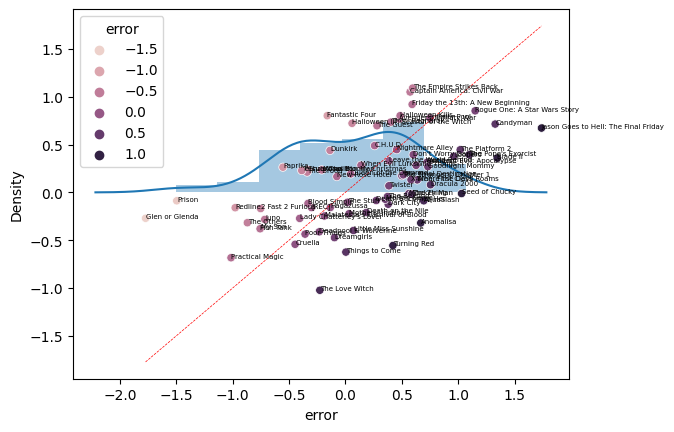

None

In [ ]:
model_features = df.select_dtypes(include=[np.number]).columns
target = 'I_VS_LB'
non_features = ['FILM_RATING_SCALED'] + [target]
model_features = [x for x in model_features if x not in non_features]

def df_to_X_y(df, model_features, target_feature):
    X = df[model_features]
    y = df[[target_feature]]
    return X, y

def fit_model(model, df, model_features, target_feature):
    X, y = df_to_X_y(df, model_features, target_feature)
    model.fit(X, y)
    return model

def score_model(model, df, model_features, target_feature):
    X, y = df_to_X_y(df, model_features, target_feature)
    display(model.score(X, y))

def predict_model(model, df, model_features, target_feature):
    X, _ = df_to_X_y(df, model_features, target_feature)
    return model.predict(X)

def model_comparison(model, df, model_features, target_feature, error_plot='error'):
    _, y_truth = df_to_X_y(df, model_features, target_feature)
    y_pred = predict_model(model, df, model_features, target_feature)
    compare_preds_df = pd.DataFrame()
    compare_preds_df['y_truth'] = y_truth
    compare_preds_df['y_predict'] = y_pred
    compare_preds_df['error'] = (compare_preds_df['y_truth'] - compare_preds_df['y_predict'])    
    compare_preds_df['absolute_error'] = np.abs(compare_preds_df['error'])
    compare_preds_df['squared_error'] = compare_preds_df['error']**2
    compare_preds_df['percent_error'] = compare_preds_df['error']/compare_preds_df['y_truth']
    compare_preds_df['absolute_percent_error'] = np.abs(compare_preds_df['percent_error'])
    display(compare_preds_df.describe())
    display(sns.distplot(compare_preds_df[error_plot]))
    return compare_preds_df

def scatter_predictions(model, df, model_features, target_feature, hue_col='error'):
    model_comparison_df = model_comparison(model, df, model_features, target_feature, hue_col)
    model_comparison_df.insert(0, 'FILM_TITLE', df['FILM_TITLE'])
    ax = sns.scatterplot(x=model_comparison_df['y_truth'], y=model_comparison_df['y_predict'], hue=model_comparison_df[hue_col])
    x = np.linspace(min(model_comparison_df['y_truth'].min(), model_comparison_df['y_predict'].min()), max(model_comparison_df['y_truth'].max(), model_comparison_df['y_predict'].max()), 100)
    plt.plot(x, x, color='r', linestyle='dashed', linewidth=0.5)
    def plotlabel(xvar, yvar, label):
        ax.text(xvar+0.002, yvar, label, size=5)
    model_comparison_df.apply(lambda x: plotlabel(x['y_truth'],  x['y_predict'], x['FILM_TITLE']), axis=1)
    display(model_comparison_df.sort_values('absolute_error', ascending=False))
    display(plt.show())

scaler = StandardScaler()
scaler.fit(df.fillna(0))

from sklearn import linear_model

simple_baseline_ols = linear_model.LinearRegression()
fit_model(simple_baseline_ols, scaler.transform(df.fillna(0)), model_features, target)

score_model(simple_baseline_ols, df.fillna(0), model_features, target)
score_model(simple_baseline_ols, df_test.fillna(0), model_features, target)

scatter_predictions(simple_baseline_ols, scaler.transform(df_test.fillna(0)), model_features, target)

In [95]:
simple_baseline_ols.coef_

array([[ 6.96973212e-08, -6.49216643e-04, -2.17084303e-02,
        -1.77378360e-01,  5.49842822e-01, -3.27445978e+00,
         5.73507428e-04,  5.23155514e-03,  2.56865594e-01,
         3.42650969e-03, -1.04498107e-01,  5.87648164e-02,
         5.68648793e-02, -6.97511061e-02, -2.01198762e-01,
        -3.83298092e-02,  1.97684141e-02, -1.64830294e-01,
         7.96263038e-02, -5.17701829e-02,  1.21700764e-01,
        -2.58418869e-01,  9.06885643e-02, -2.53130850e-14,
        -1.78572785e-01,  1.54920425e-01,  2.26173005e-02,
         2.67387490e-02,  1.11565658e-01,  2.21000956e-01,
         1.14748116e-02,  9.77317678e-02, -9.42058230e-02,
        -9.05255430e-02,  1.96776951e-01, -2.12295004e-01,
        -1.31313272e-01, -1.28458398e-01,  1.76894431e-02,
        -5.29417146e-02,  2.66375873e-01,  2.04003435e-01,
        -4.48330565e-02, -1.80071958e-01, -5.27346303e-02,
         1.42879925e-01,  5.35027959e-02,  3.19636012e-03,
        -2.49703941e-02,  4.18689652e-01, -1.18776789e-0

In [19]:
for feature in rated_features.columns:
    display(rated_features[[feature]].describe(percentiles=[.05, .25, .5, .75, .95]))

,FILM_ID
count,1476
unique,1476
top,f_01ZLI
freq,1


,FILM_TITLE
count,1476
unique,1453
top,Halloween
freq,3


,FILM_WATCH_COUNT
count,1476.00
mean,593539.00
std,850470.15
min,129.00
5%,10577.00
25%,66470.25
50%,230596.00
75%,720887.50
95%,2588964.00
max,5023023.00


,FILM_TOP_250
count,1476.00
mean,259.50
std,34.29
min,2.00
5%,266.00
25%,266.00
50%,266.00
75%,266.00
95%,266.00
max,266.00


,FILM_IS_TOP_250
count,1476.00
mean,0.04
std,0.20
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,FILM_RATING
count,1476.00
mean,3.28
std,0.60
min,0.00
5%,2.24
25%,2.88
50%,3.32
75%,3.72
95%,4.19
max,4.63


,LIKES_PER_WATCH
count,1476.00
mean,0.22
std,0.09
min,0.03
5%,0.09
25%,0.15
50%,0.22
75%,0.28
95%,0.37
max,0.55


,FANS_PER_WATCH
count,1476.00
mean,0.01
std,0.01
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.01
95%,0.02
max,0.07


,FILM_RUNTIME
count,1476.00
mean,106.72
std,21.16
min,0.00
5%,80.00
25%,92.00
50%,102.00
75%,118.00
95%,147.00
max,201.00


,FILM_YEAR
count,1476.00
mean,2003.40
std,18.07
min,1920.00
5%,1971.00
25%,1993.00
50%,2007.00
75%,2019.00
95%,2023.00
max,2024.00


,DIRECTOR_MEAN_RATING
count,1476.00
mean,3.18
std,0.55
min,0.00
5%,2.81
25%,2.81
50%,2.81
75%,3.58
95%,4.21
max,4.69


,DIRECTOR_TOTAL_FILMS
count,1476.00
mean,8.90
std,8.56
min,0.00
5%,1.00
25%,3.00
50%,6.00
75%,12.00
95%,23.00
max,91.00


,DIRECTOR_PERCENT_WATCHED
count,1476.00
mean,0.56
std,0.30
min,0.00
5%,0.12
25%,0.33
50%,0.50
75%,0.86
95%,1.00
max,1.00


,action
count,1476.00
mean,0.24
std,0.43
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,1.00
max,1.00


,adventure
count,1476.00
mean,0.18
std,0.39
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,1.00
max,1.00


,animation
count,1476.00
mean,0.06
std,0.23
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,1.00
max,1.00


,comedy
count,1476.00
mean,0.21
std,0.41
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,1.00
max,1.00


,crime
count,1476.00
mean,0.11
std,0.31
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,1.00
max,1.00


,drama
count,1476.00
mean,0.28
std,0.45
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,1.00
95%,1.00
max,1.00


,family
count,1476.00
mean,0.07
std,0.26
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,1.00
max,1.00


,fantasy
count,1476.00
mean,0.14
std,0.35
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,1.00
max,1.00


,history
count,1476.00
mean,0.02
std,0.14
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,horror
count,1476.00
mean,0.44
std,0.50
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,1.00
95%,1.00
max,1.00


,music
count,1476.00
mean,0.02
std,0.15
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,mystery
count,1476.00
mean,0.17
std,0.37
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,1.00
max,1.00


,none
count,1476.00
mean,0.00
std,0.00
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,0.00


,romance
count,1476.00
mean,0.07
std,0.25
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,1.00
max,1.00


,science-fiction
count,1476.00
mean,0.26
std,0.44
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,1.00
95%,1.00
max,1.00


,thriller
count,1476.00
mean,0.37
std,0.48
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,1.00
95%,1.00
max,1.00


,tv-movie
count,1476.00
mean,0.00
std,0.05
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,war
count,1476.00
mean,0.01
std,0.11
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,western
count,1476.00
mean,0.01
std,0.07
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,2000s
count,1476.00
mean,0.01
std,0.08
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,adventurer
count,1476.00
mean,0.01
std,0.08
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,aftercreditsstinger
count,1476.00
mean,0.07
std,0.25
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,1.00
max,1.00


,aggressive
count,1476.00
mean,0.02
std,0.13
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,alien
count,1476.00
mean,0.04
std,0.18
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,alien invasion
count,1476.00
mean,0.01
std,0.12
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,alien life-form
count,1476.00
mean,0.01
std,0.10
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,amused
count,1476.00
mean,0.02
std,0.14
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,amusement park
count,1476.00
mean,0.01
std,0.08
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,android
count,1476.00
mean,0.01
std,0.11
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,animal horror
count,1476.00
mean,0.01
std,0.10
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,antagonistic
count,1476.00
mean,0.01
std,0.09
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,anthropomorphism
count,1476.00
mean,0.01
std,0.11
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,anti hero
count,1476.00
mean,0.01
std,0.11
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,anxious
count,1476.00
mean,0.01
std,0.12
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,apocalypse
count,1476.00
mean,0.01
std,0.10
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,archaeologist
count,1476.00
mean,0.01
std,0.09
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,army
count,1476.00
mean,0.01
std,0.11
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,artificial intelligence (a.i.)
count,1476.00
mean,0.02
std,0.15
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,astronaut
count,1476.00
mean,0.01
std,0.10
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,audacious
count,1476.00
mean,0.01
std,0.09
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,awestruck
count,1476.00
mean,0.01
std,0.10
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,babysitter
count,1476.00
mean,0.01
std,0.08
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,based on comic
count,1476.00
mean,0.06
std,0.23
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,1.00
max,1.00


,basement
count,1476.00
mean,0.01
std,0.07
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,bible
count,1476.00
mean,0.01
std,0.08
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,black magic
count,1476.00
mean,0.01
std,0.08
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,body horror
count,1476.00
mean,0.02
std,0.13
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,bold
count,1476.00
mean,0.01
std,0.08
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,brutality
count,1476.00
mean,0.02
std,0.13
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,callous
count,1476.00
mean,0.00
std,0.07
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,car race
count,1476.00
mean,0.01
std,0.10
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,cautionary
count,1476.00
mean,0.01
std,0.09
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,celebratory
count,1476.00
mean,0.00
std,0.07
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,chainsaw
count,1476.00
mean,0.01
std,0.07
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,church
count,1476.00
mean,0.01
std,0.12
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,clown
count,1476.00
mean,0.01
std,0.08
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,complex
count,1476.00
mean,0.01
std,0.09
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,computer
count,1476.00
mean,0.01
std,0.08
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,corpse
count,1476.00
mean,0.01
std,0.11
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,creature
count,1476.00
mean,0.04
std,0.19
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,cruelty
count,1476.00
mean,0.01
std,0.08
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,cult
count,1476.00
mean,0.01
std,0.10
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,cyberpunk
count,1476.00
mean,0.02
std,0.13
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,cyborg
count,1476.00
mean,0.01
std,0.10
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,cynical
count,1476.00
mean,0.00
std,0.07
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,death game
count,1476.00
mean,0.01
std,0.12
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,decapitation
count,1476.00
mean,0.01
std,0.11
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,demon
count,1476.00
mean,0.03
std,0.17
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,demonic possession
count,1476.00
mean,0.01
std,0.12
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,desperate
count,1476.00
mean,0.01
std,0.08
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,disturbed
count,1476.00
mean,0.01
std,0.09
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,doppelgänger
count,1476.00
mean,0.01
std,0.08
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,dracula
count,1476.00
mean,0.01
std,0.07
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,dramatic
count,1476.00
mean,0.02
std,0.13
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,duel
count,1476.00
mean,0.01
std,0.07
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,duringcreditsstinger
count,1476.00
mean,0.07
std,0.26
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,1.00
max,1.00


,dystopia
count,1476.00
mean,0.07
std,0.25
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,1.00
max,1.00


,end of the world
count,1476.00
mean,0.01
std,0.08
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,evil
count,1476.00
mean,0.02
std,0.13
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,ex-cop
count,1476.00
mean,0.00
std,0.07
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,excited
count,1476.00
mean,0.01
std,0.09
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,existentialism
count,1476.00
mean,0.01
std,0.09
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,exorcism
count,1476.00
mean,0.01
std,0.11
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,fantasy world
count,1476.00
mean,0.01
std,0.09
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,fate
count,1476.00
mean,0.01
std,0.07
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,female villain
count,1476.00
mean,0.01
std,0.07
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,flying
count,1476.00
mean,0.01
std,0.07
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,folk horror
count,1476.00
mean,0.01
std,0.11
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,frightened
count,1476.00
mean,0.01
std,0.12
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,future
count,1476.00
mean,0.02
std,0.15
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,futuristic
count,1476.00
mean,0.01
std,0.09
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,gas station
count,1476.00
mean,0.01
std,0.08
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,good versus evil
count,1476.00
mean,0.02
std,0.13
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,gore
count,1476.00
mean,0.04
std,0.20
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,gothic
count,1476.00
mean,0.01
std,0.11
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,gothic horror
count,1476.00
mean,0.01
std,0.09
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,grave
count,1476.00
mean,0.01
std,0.08
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,grief
count,1476.00
mean,0.02
std,0.13
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,guilt
count,1476.00
mean,0.01
std,0.09
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,hacker
count,1476.00
mean,0.01
std,0.08
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,halloween
count,1476.00
mean,0.03
std,0.17
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,hallucination
count,1476.00
mean,0.02
std,0.13
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,haunted house
count,1476.00
mean,0.02
std,0.13
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,homicide
count,1476.00
mean,0.01
std,0.08
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,hopeful
count,1476.00
mean,0.01
std,0.09
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,horrified
count,1476.00
mean,0.01
std,0.11
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,horror comedy
count,1476.00
mean,0.01
std,0.08
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,immortality
count,1476.00
mean,0.01
std,0.09
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,insanity
count,1476.00
mean,0.01
std,0.12
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,intense
count,1476.00
mean,0.02
std,0.13
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,isolation
count,1476.00
mean,0.01
std,0.12
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,joyful
count,1476.00
mean,0.00
std,0.07
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,killer
count,1476.00
mean,0.02
std,0.13
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,laboratory
count,1476.00
mean,0.01
std,0.08
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,lake
count,1476.00
mean,0.01
std,0.09
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,live action remake
count,1476.00
mean,0.00
std,0.07
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,macabre
count,1476.00
mean,0.01
std,0.10
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,mad scientist
count,1476.00
mean,0.01
std,0.11
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,madness
count,1476.00
mean,0.01
std,0.09
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,magic
count,1476.00
mean,0.03
std,0.16
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,maniac
count,1476.00
mean,0.01
std,0.09
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,mansion
count,1476.00
mean,0.01
std,0.10
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,marvel cinematic universe (mcu)
count,1476.00
mean,0.02
std,0.14
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,mask
count,1476.00
mean,0.02
std,0.15
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,mass murder
count,1476.00
mean,0.01
std,0.08
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,melodramatic
count,1476.00
mean,0.01
std,0.07
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,memory loss
count,1476.00
mean,0.01
std,0.09
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,mental institution
count,1476.00
mean,0.00
std,0.07
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,missing child
count,1476.00
mean,0.00
std,0.06
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,mission
count,1476.00
mean,0.01
std,0.10
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,morgue
count,1476.00
mean,0.00
std,0.07
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,murder mystery
count,1476.00
mean,0.01
std,0.09
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,murderer
count,1476.00
mean,0.01
std,0.08
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,mutant
count,1476.00
mean,0.02
std,0.14
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,mutation
count,1476.00
mean,0.01
std,0.09
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,mysterious
count,1476.00
mean,0.01
std,0.10
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,nasa
count,1476.00
mean,0.00
std,0.07
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,new england
count,1476.00
mean,0.00
std,0.07
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,new jersey
count,1476.00
mean,0.01
std,0.10
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,nostalgic
count,1476.00
mean,0.01
std,0.09
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,nurse
count,1476.00
mean,0.01
std,0.11
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,occult
count,1476.00
mean,0.01
std,0.12
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,ominous
count,1476.00
mean,0.01
std,0.07
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,paranoia
count,1476.00
mean,0.02
std,0.14
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,"philadelphia, pennsylvania"
count,1476.00
mean,0.01
std,0.08
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,philosophical
count,1476.00
mean,0.01
std,0.08
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,philosophy
count,1476.00
mean,0.01
std,0.08
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,playful
count,1476.00
mean,0.01
std,0.10
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,possession
count,1476.00
mean,0.02
std,0.14
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,powerful
count,1476.00
mean,0.01
std,0.09
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,prequel
count,1476.00
mean,0.01
std,0.11
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,prophecy
count,1476.00
mean,0.01
std,0.10
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,psychic
count,1476.00
mean,0.01
std,0.08
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,psychological thriller
count,1476.00
mean,0.02
std,0.14
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,psychopath
count,1476.00
mean,0.04
std,0.20
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,psychotic
count,1476.00
mean,0.01
std,0.07
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,psychotronic
count,1476.00
mean,0.01
std,0.10
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,puppet
count,1476.00
mean,0.00
std,0.07
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,race against time
count,1476.00
mean,0.01
std,0.10
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,reboot
count,1476.00
mean,0.01
std,0.09
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,riddle
count,1476.00
mean,0.01
std,0.09
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,ridiculous
count,1476.00
mean,0.01
std,0.08
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,ritual
count,1476.00
mean,0.01
std,0.08
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,sacrifice
count,1476.00
mean,0.01
std,0.09
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,sadism
count,1476.00
mean,0.03
std,0.17
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,satanism
count,1476.00
mean,0.01
std,0.07
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,saving the world
count,1476.00
mean,0.02
std,0.12
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,scientist
count,1476.00
mean,0.03
std,0.16
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,secret identity
count,1476.00
mean,0.01
std,0.10
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,secret organization
count,1476.00
mean,0.01
std,0.07
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,secret society
count,1476.00
mean,0.01
std,0.08
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,self sacrifice
count,1476.00
mean,0.01
std,0.07
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,serial killer
count,1476.00
mean,0.07
std,0.25
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,1.00
max,1.00


,series of murders
count,1476.00
mean,0.01
std,0.12
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,shocking
count,1476.00
mean,0.01
std,0.10
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,shotgun
count,1476.00
mean,0.01
std,0.09
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,sign languages
count,1476.00
mean,0.01
std,0.08
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,slasher
count,1476.00
mean,0.05
std,0.22
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,sociopath
count,1476.00
mean,0.01
std,0.08
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,space
count,1476.00
mean,0.02
std,0.15
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,space marine
count,1476.00
mean,0.01
std,0.11
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,space opera
count,1476.00
mean,0.02
std,0.12
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,space travel
count,1476.00
mean,0.02
std,0.12
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,spacecraft
count,1476.00
mean,0.01
std,0.12
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,spin off
count,1476.00
mean,0.01
std,0.09
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,steampunk
count,1476.00
mean,0.01
std,0.08
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,stop motion
count,1476.00
mean,0.01
std,0.09
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,summer camp
count,1476.00
mean,0.01
std,0.07
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,superhero
count,1476.00
mean,0.05
std,0.21
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,supernatural horror
count,1476.00
mean,0.02
std,0.13
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,supernatural power
count,1476.00
mean,0.01
std,0.12
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,surrealism
count,1476.00
mean,0.03
std,0.16
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,survival horror
count,1476.00
mean,0.02
std,0.13
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,suspenseful
count,1476.00
mean,0.02
std,0.15
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,telekinesis
count,1476.00
mean,0.01
std,0.08
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,telepathy
count,1476.00
mean,0.01
std,0.07
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,time loop
count,1476.00
mean,0.01
std,0.07
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,time travel
count,1476.00
mean,0.03
std,0.16
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,tragic
count,1476.00
mean,0.01
std,0.08
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,transformation
count,1476.00
mean,0.02
std,0.13
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,treasure hunt
count,1476.00
mean,0.01
std,0.08
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,undead
count,1476.00
mean,0.01
std,0.08
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,urban legend
count,1476.00
mean,0.01
std,0.07
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,urban setting
count,1476.00
mean,0.01
std,0.07
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,victim
count,1476.00
mean,0.01
std,0.07
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,video nasty
count,1476.00
mean,0.01
std,0.10
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,villain
count,1476.00
mean,0.03
std,0.18
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,violence
count,1476.00
mean,0.01
std,0.11
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,virtual reality
count,1476.00
mean,0.01
std,0.09
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,virus
count,1476.00
mean,0.01
std,0.10
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,voodoo
count,1476.00
mean,0.01
std,0.08
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,voyeurism
count,1476.00
mean,0.01
std,0.10
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,whimsical
count,1476.00
mean,0.01
std,0.09
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,whodunit
count,1476.00
mean,0.02
std,0.15
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,winter
count,1476.00
mean,0.01
std,0.10
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,witch
count,1476.00
mean,0.03
std,0.16
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,witchcraft
count,1476.00
mean,0.01
std,0.09
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,witty
count,1476.00
mean,0.01
std,0.07
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,wizard
count,1476.00
mean,0.01
std,0.11
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,woods
count,1476.00
mean,0.02
std,0.14
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,zombie
count,1476.00
mean,0.03
std,0.18
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,zombie apocalypse
count,1476.00
mean,0.01
std,0.07
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,Harrison Ford
count,1476.00
mean,0.01
std,0.10
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,Tom Hanks
count,1476.00
mean,0.01
std,0.08
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,Bruce Willis
count,1476.00
mean,0.01
std,0.09
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,Gary Oldman
count,1476.00
mean,0.01
std,0.10
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,Johnny Depp
count,1476.00
mean,0.00
std,0.06
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,Cate Blanchett
count,1476.00
mean,0.01
std,0.09
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,Christopher Lee
count,1476.00
mean,0.01
std,0.09
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,Jake Gyllenhaal
count,1476.00
mean,0.01
std,0.08
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,Brad Pitt
count,1476.00
mean,0.01
std,0.10
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,Robert De Niro
count,1476.00
mean,0.01
std,0.07
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,Tom Cruise
count,1476.00
mean,0.01
std,0.10
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,Steve Buscemi
count,1476.00
mean,0.01
std,0.09
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,Owen Wilson
count,1476.00
mean,0.01
std,0.10
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,John Goodman
count,1476.00
mean,0.01
std,0.09
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,Scarlett Johansson
count,1476.00
mean,0.01
std,0.10
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,Bill Murray
count,1476.00
mean,0.01
std,0.09
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,Matt Damon
count,1476.00
mean,0.01
std,0.11
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,Brendan Gleeson
count,1476.00
mean,0.01
std,0.08
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,Samuel L. Jackson
count,1476.00
mean,0.02
std,0.14
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,Nicolas Cage
count,1476.00
mean,0.01
std,0.11
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,Laurence Fishburne
count,1476.00
mean,0.01
std,0.09
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,Tilda Swinton
count,1476.00
mean,0.01
std,0.10
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,Liam Neeson
count,1476.00
mean,0.01
std,0.07
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,Christopher Walken
count,1476.00
mean,0.01
std,0.08
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,John Hurt
count,1476.00
mean,0.01
std,0.09
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,Willem Dafoe
count,1476.00
mean,0.01
std,0.12
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,Ralph Fiennes
count,1476.00
mean,0.01
std,0.09
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,Hugh Jackman
count,1476.00
mean,0.01
std,0.10
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,Stan Lee
count,1476.00
mean,0.02
std,0.14
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,John Ratzenberger
count,1476.00
mean,0.01
std,0.10
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,Jamie Lee Curtis
count,1476.00
mean,0.01
std,0.11
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,Elizabeth Banks
count,1476.00
mean,0.00
std,0.06
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,David Thewlis
count,1476.00
mean,0.01
std,0.09
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,Vin Diesel
count,1476.00
mean,0.01
std,0.11
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,Toby Jones
count,1476.00
mean,0.01
std,0.08
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,Frank Welker
count,1476.00
mean,0.02
std,0.12
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,Chris Evans
count,1476.00
mean,0.01
std,0.12
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,Josh Brolin
count,1476.00
mean,0.01
std,0.08
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,Michael Fassbender
count,1476.00
mean,0.01
std,0.09
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,Idris Elba
count,1476.00
mean,0.01
std,0.10
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,J.K. Simmons
count,1476.00
mean,0.01
std,0.09
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,Jack Angel
count,1476.00
mean,0.01
std,0.10
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,Alan Tudyk
count,1476.00
mean,0.01
std,0.08
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,Channing Tatum
count,1476.00
mean,0.01
std,0.10
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,Thomas Rosales Jr.
count,1476.00
mean,0.01
std,0.10
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,Mickie McGowan
count,1476.00
mean,0.01
std,0.10
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,Sherry Lynn
count,1476.00
mean,0.01
std,0.10
min,0.00
5%,0.00
25%,0.00
50%,0.00
75%,0.00
95%,0.00
max,1.00


,FILM_RATING_SCALED
count,1476.00
mean,3.36
std,0.85
min,0.38
5%,1.76
25%,2.89
50%,3.42
75%,3.93
95%,4.73
max,5.00


,I_VS_LB
count,1476.00
mean,0.08
std,0.69
min,-2.72
5%,-1.14
25%,-0.29
50%,0.17
75%,0.50
95%,1.06
max,3.76


In [5]:
rating_features_df_test = rating_features_df.copy()
lower_limit = np.percentile(rating_features_df_test["FILM_WATCH_COUNT"], 5)
upper_limit = np.percentile(rating_features_df_test["FILM_WATCH_COUNT"], 95)
print(lower_limit, upper_limit)


731.4000000000001 541737.9999999999


In [6]:
rating_features_df_test['FILM_WATCH_COUNT_CAPPED'] = np.where(rating_features_df_test["FILM_WATCH_COUNT"] < lower_limit, lower_limit, rating_features_df_test['FILM_WATCH_COUNT'])
rating_features_df_test['FILM_WATCH_COUNT_CAPPED'] = np.where(rating_features_df_test["FILM_WATCH_COUNT"] > upper_limit, upper_limit, rating_features_df_test['FILM_WATCH_COUNT_CAPPED'])

(0.0, 750000.0)

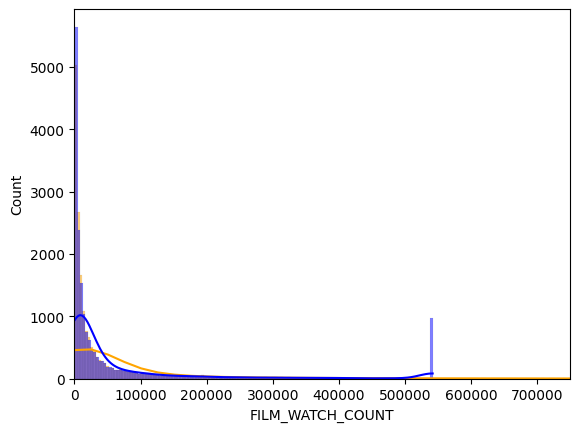

In [7]:
sns.histplot(rating_features_df, x='FILM_WATCH_COUNT', kde=True, color='orange')
sns.histplot(rating_features_df_test, x='FILM_WATCH_COUNT_CAPPED', kde=True, color='blue')
plt.xlim(0, 750000)

In [8]:
def analyse_col(col_name):
    agg_df = rated_features.groupby(col_name).agg({'FILM_ID':'count', 'FILM_RATING':'mean', 'FILM_RATING_SCALED':'mean', 'I_VS_LB':'mean'})
    if len(agg_df) <= 5:
        display(agg_df)
        all_titles = list(rated_features[rated_features[col_name] == 1]['FILM_TITLE'].values)
        display(', '.join(all_titles))
        fig, ax = plt.subplots(2, 2, figsize=(10, 10))
        ax = ax.flatten()
        sns.histplot(rated_features, x='FILM_RATING_SCALED', hue=col_name, kde=True, ax=ax[0])
        sns.ecdfplot(rated_features, x='FILM_RATING_SCALED', hue=col_name, ax=ax[1])
        sns.histplot(rated_features, x='I_VS_LB', hue=col_name, kde=True, ax=ax[2])
        sns.ecdfplot(rated_features, x='I_VS_LB', hue=col_name, ax=ax[3])
    else:
        display(rated_features[[col_name]].describe(percentiles=[0.01, 0.05, 0.1, 0.9, 0.95, 0.99]))
        fig, ax = plt.subplots(1, 2, figsize=(10, 5))
        ax = ax.flatten()
        sns.histplot(rating_features_df, x=col_name, kde=True, ax=ax[0])
        sns.ecdfplot(rating_features_df, x=col_name, ax=ax[1])

<AxesSubplot:ylabel='Frequency'>

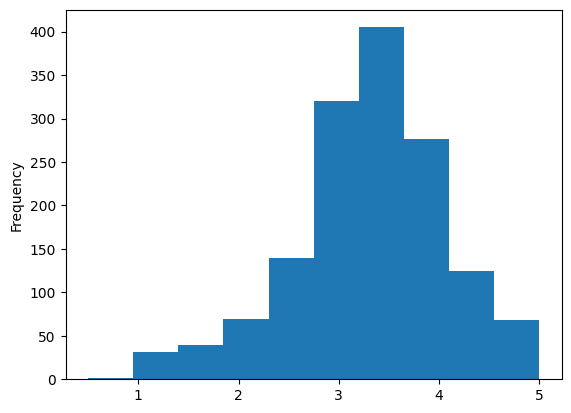

In [9]:
basic_rating_df = select_statement_to_df('SELECT * FROM PERSONAL_RATING')
basic_rating_df['FILM_RATING_BASIC'].plot(kind='hist', bins=10)

,index,FILM_RATING_BASIC
9,0.50,2
8,1.00,31
7,1.50,40
5,2.00,69
3,2.50,140
1,3.00,320
0,3.50,405
2,4.00,276
4,4.50,125
6,5.00,68


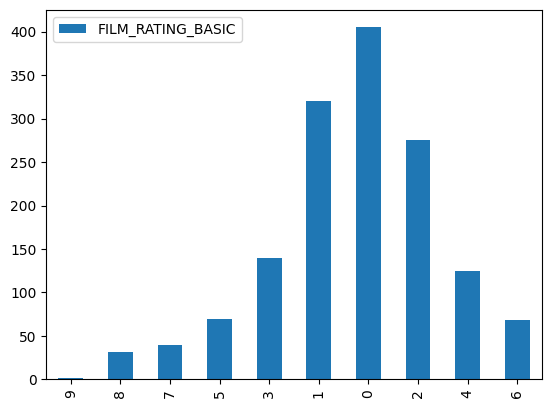

In [10]:
pd.DataFrame(basic_rating_df['FILM_RATING_BASIC'].value_counts()).reset_index().sort_values('index')[['FILM_RATING_BASIC']].plot(kind='bar')
pd.DataFrame(basic_rating_df['FILM_RATING_BASIC'].value_counts()).reset_index().sort_values('index')

,FILM_ID,FILM_RATING,FILM_RATING_SCALED,I_VS_LB
science-fiction,,,,
0,1085,3.30,3.30,-0.00
1,391,3.21,3.52,0.32


"Altered States, The Faculty, Sea Fever, Dredd, Pacific Rim, Dark City, The Blob, Darkman, The Fifth Element, Village of the Damned, Things to Come, Hotel Artemis, Ad Astra, The Interceptor, Metropolis, Frankenstein, The Invisible Man, Spider-Man: Into the Spider-Verse, The Empire Strikes Back, 2001: A Space Odyssey, Alien, The Thing, Star Wars, Back to the Future, Children of Men, Eternal Sunshine of the Spotless Mind, Terminator 2: Judgment Day, Akira, Inception, Mad Max: Fury Road, Blade Runner, Dune, Creature from the Black Lagoon, Cloverfield, The Brood, Interstellar, Black Panther, Avengers: Endgame, Arrival, Avengers: Infinity War, Guardians of the Galaxy, Blade Runner 2049, Star Wars: The Force Awakens, Thor: Ragnarok, Tenet, The Avengers, Spider-Man: Homecoming, Star Wars: The Last Jedi, The Matrix, Guardians of the Galaxy Vol. 2, Logan, Star Wars: The Rise of Skywalker, Captain Marvel, WALL·E, Jurassic Park, Rogue One: A Star Wars Story, Spider-Man: Far From Home, The Martian

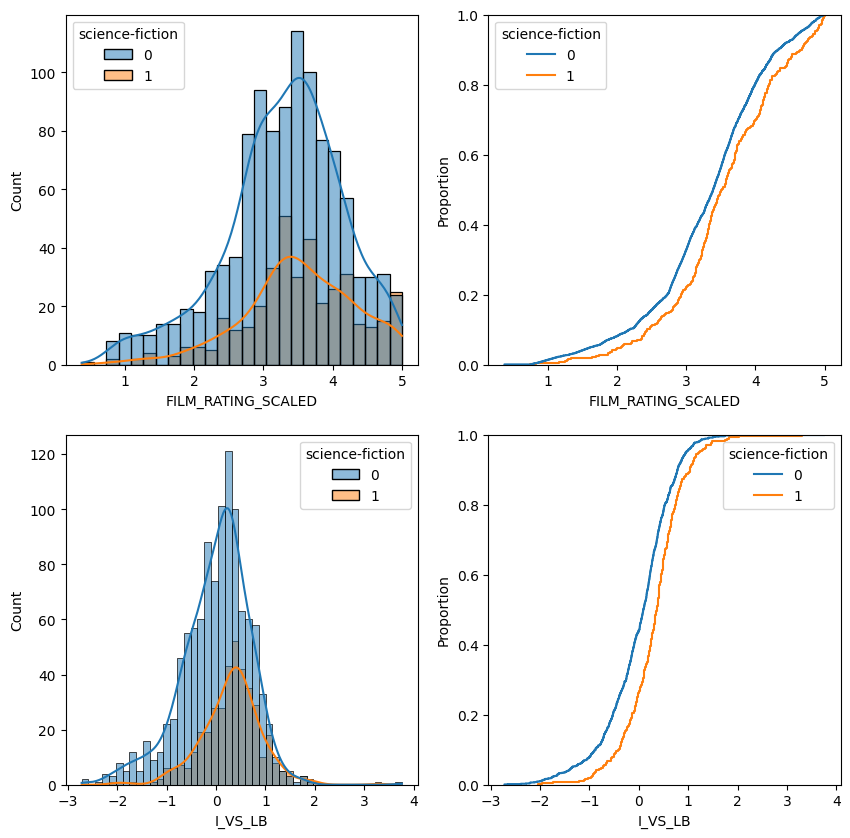

In [12]:
analyse_col('science-fiction')

,FILM_WATCH_COUNT
count,1476.00
mean,593539.00
std,850470.15
min,129.00
1%,2274.50
5%,10577.00
10%,21685.00
50%,230596.00
90%,1739090.00
95%,2588964.00


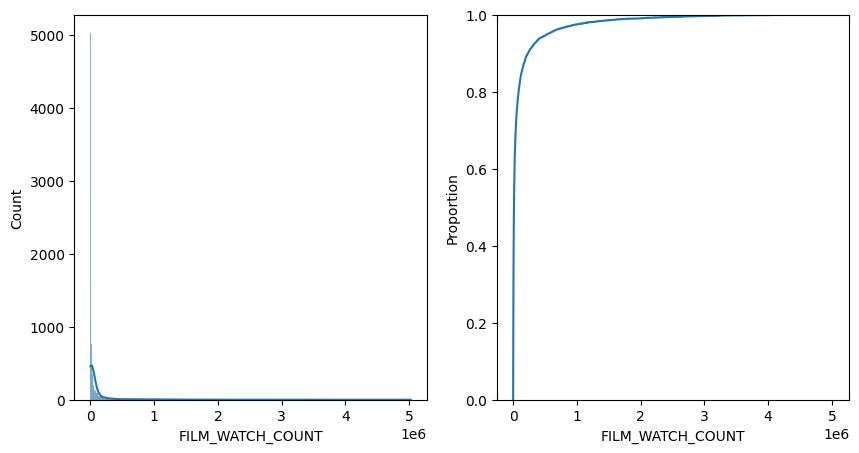

In [13]:
analyse_col('FILM_WATCH_COUNT')

<AxesSubplot:xlabel='FILM_WATCH_COUNT', ylabel='Count'>

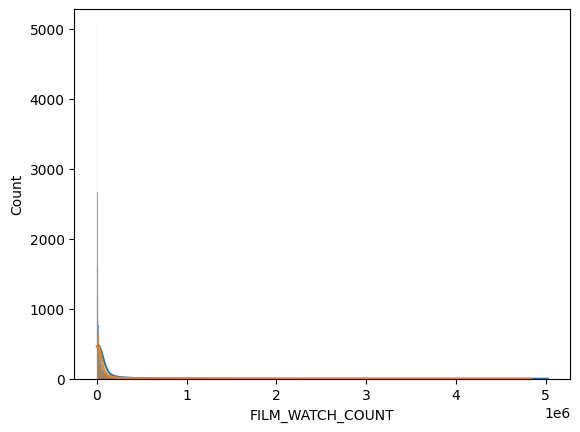

In [14]:
sns.histplot(rating_features_df, x='FILM_WATCH_COUNT', kde=True)
sns.histplot(unrated_features, x='FILM_WATCH_COUNT', kde=True)

In [15]:
non_features = ['FILM_ID',
                'FILM_TITLE',
                # 'FILM_RATING',
                'FILM_RATING_SCALED',
                'FILM_RUNTIME',
                'FILM_WATCH_COUNT',
                'FILM_FAN_COUNT',
                'FILM_YEAR',
                'FILM_TOP_250',
                # 'DIRECTOR_MEAN_RATING',
                # 'DIRECTOR_TOTAL_FILMS',
                # 'DIRECTOR_PERCENT_WATCHED',
                'new jersey',
                'philadelphia, pennsylvania',
                'I_VS_LB'
                ]
model_features = [x for x in unrated_features.columns if x not in non_features]
delete_cols = []
for col in model_features:
    col_mean = rated_features[col].mean()
    if len(rated_features[col].unique()) == 2 and col_mean < .01:
        delete_cols.append(col)
print(delete_cols)
model_features = [x for x in model_features if x not in delete_cols]
target = 'I_VS_LB'
X_train = rated_features[model_features]
y_train = rated_features[[target]]
y_train = np.clip(y_train, np.percentile(y_train, 1), np.percentile(y_train, 99))
# y_train = np.square(y_train)
print('Data gathering complete!')
print('Scaling features...')
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
print('Features Scaled!')
print('Training model...')
valid_model_types = ['xgboost', 'decision_tree', 'linear_regression']
model_type = 'xgboost'
if model_type == 'xgboost':
    model = XGBRegressor(min_child_weight=5)
elif model_type == 'decision_tree':
    model = DecisionTreeRegressor(min_samples_leaf=5)
elif model_type == 'linear_regression':
    model = LinearRegression()
model.fit(X_train, y_train)
print('Model train complete!')
print('Making predictions...')
X_pred = unrated_features[model_features]
X_pred = scaler.transform(X_pred)
pred_df = unrated_features.copy()
pred_df[target+'_PRED'] = model.predict(X_pred)
# pred_df['FILM_RATING_PRED'] = np.sqrt(model.predict(X_pred))
print('Predictions complete!')
pred_df['FILM_RATING_PRED'] = pred_df['FILM_RATING'] + pred_df[target+'_PRED']
pred_df = scale_col(pred_df, 'FILM_RATING_PRED', a=0, b=5)
# pred_df = scale_col(pred_df, target+'_PRED', a=0, b=1)
model.score(X_train, y_train)

['tv-movie', 'western', '2000s', 'adventurer', 'amusement park', 'animal horror', 'antagonistic', 'apocalypse', 'archaeologist', 'audacious', 'awestruck', 'babysitter', 'baffled', 'basement', 'bible', 'black magic', 'bold', 'car race', 'cautionary', 'celebratory', 'chainsaw', 'clown', 'complex', 'computer', 'cruelty', 'desperate', 'disturbed', 'doppelgänger', 'dracula', 'duel', 'ex-cop', 'excited', 'existentialism', 'fantasy world', 'female villain', 'flying', 'futuristic', 'gas station', 'gothic horror', 'grave', 'guilt', 'hacker', 'homicide', 'hopeful', 'horror comedy', 'immortality', 'laboratory', 'lake', 'live action remake', 'madness', 'maniac', 'mass murder', 'melodramatic', 'memory loss', 'mental institution', 'missing child', 'mission', 'morgue', 'murder mystery', 'murderer', 'mutation', 'nasa', 'new england', 'nostalgic', 'ominous', 'philosophical', 'philosophy', 'playful', 'powerful', 'prophecy', 'psychic', 'psychotic', 'psychotronic', 'puppet', 'race against time', 'reboot',

0.9105888004630096

C:\Users\tom\AppData\Local\Temp\ipykernel_3272\375460187.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train)


<AxesSubplot:ylabel='Density'>

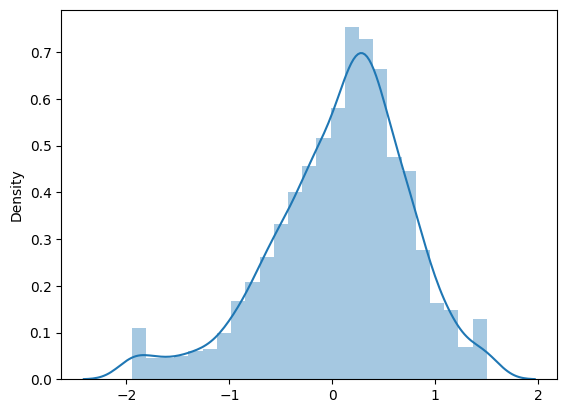

In [16]:
sns.distplot(y_train)

C:\Users\tom\AppData\Local\Temp\ipykernel_3272\2780947421.py:2: RuntimeWarning: divide by zero encountered in log
  y_train_log = np.log(y_train_)
C:\Users\tom\AppData\Local\Temp\ipykernel_3272\2780947421.py:13: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(min_max_scale(y_train_), color='red')
C:\Users\tom\AppData\Local\Temp\ipykernel_3272\2780947421.py:17: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use 

<AxesSubplot:ylabel='Density'>

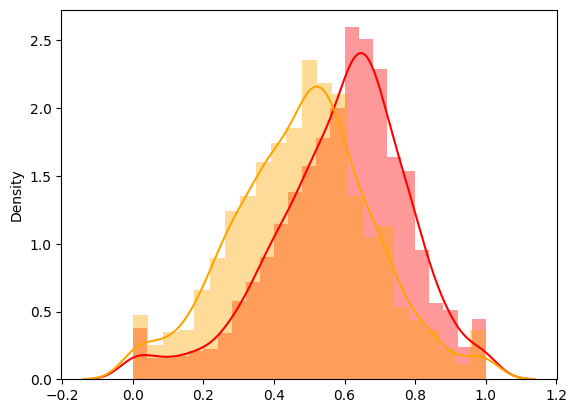

In [17]:
y_train_ = min_max_scale(y_train.iloc[:, 0].values)
y_train_log = np.log(y_train_)

y_train_squared = np.square(y_train_)

from scipy.stats import boxcox
y_train_boxcox, lambda_ = boxcox(1+y_train_)

from sklearn.preprocessing import PowerTransformer
pt = PowerTransformer(method='yeo-johnson')
y_train_transformed_pt = pt.fit_transform(y_train_.reshape(-1, 1))

sns.distplot(min_max_scale(y_train_), color='red')
# sns.distplot(min_max_scale(y_train_squared), color='blue')
# sns.distplot(min_max_scale(y_train_log), color='green')
# sns.distplot(min_max_scale(y_train_boxcox), color='grey')
sns.distplot(min_max_scale(y_train_transformed_pt), color='orange')

In [18]:
# pred_df.sort_values(target+'_PRED', ascending=False).tail(50)
pred_df.sort_values('FILM_RATING_PRED', ascending=False).head(50)

,FILM_ID,FILM_TITLE,FILM_WATCH_COUNT,FILM_TOP_250,FILM_IS_TOP_250,FILM_RATING,LIKES_PER_WATCH,FANS_PER_WATCH,FILM_RUNTIME,FILM_YEAR,...,Jack Angel,Alan Tudyk,Channing Tatum,Thomas Rosales Jr.,Mickie McGowan,Sherry Lynn,FILM_RATING_SCALED,I_VS_LB,I_VS_LB_PRED,FILM_RATING_PRED
1925,f_0eCrQ,Kill Bill: The Whole Bloody Affair,123871,266.00,0,4.35,0.27,0.03,247.00,2006,...,0.00,0.00,0.00,0.00,0.00,0.00,NaN,NaN,0.62,5.00
4,f_02aq2,Schindler's List,1557920,13.00,1,4.53,0.31,0.01,195.00,1993,...,0.00,0.00,0.00,0.00,0.00,0.00,NaN,NaN,0.42,4.98
17502,f_00Msm,Incendies,408632,44.00,1,4.42,0.38,0.03,131.00,2010,...,0.00,0.00,0.00,0.00,0.00,0.00,NaN,NaN,0.46,4.92
344,f_04E5i,Prisoners,1889642,143.00,1,4.30,0.37,0.02,153.00,2013,...,0.00,0.00,0.00,0.00,0.00,0.00,NaN,NaN,0.50,4.87
4084,f_01dJa,The Human Condition II: Road to Eternity,26335,37.00,1,4.43,0.38,0.00,178.00,1959,...,0.00,0.00,0.00,0.00,0.00,0.00,NaN,NaN,0.26,4.77
709,f_01VFw,Mulan,1673255,266.00,0,4.12,0.26,0.01,88.00,1998,...,0.00,0.00,0.00,0.00,0.00,0.00,NaN,NaN,0.55,4.76
27,f_023um,Boogie Nights,639432,266.00,0,4.21,0.33,0.02,156.00,1997,...,0.00,0.00,0.00,0.00,0.00,0.00,NaN,NaN,0.44,4.75
818,f_01ZPg,Mad Max 2,311637,266.00,0,3.89,0.29,0.00,96.00,1981,...,0.00,0.00,0.00,0.00,0.00,0.00,NaN,NaN,0.76,4.75
3714,f_02aCM,The Celebration,135688,151.00,1,4.30,0.32,0.02,105.00,1998,...,0.00,0.00,0.00,0.00,0.00,0.00,NaN,NaN,0.34,4.74
5671,f_01vXk,Ace in the Hole,67974,193.00,1,4.26,0.32,0.00,111.00,1951,...,0.00,0.00,0.00,0.00,0.00,0.00,NaN,NaN,0.37,4.73


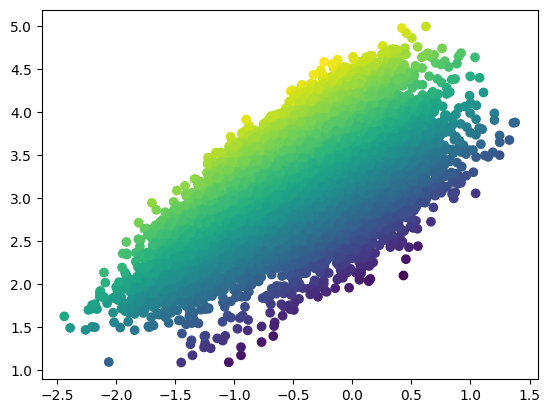

In [19]:
plt.scatter(data=pred_df[pred_df['FILM_RATING']>0], x='I_VS_LB_PRED', y='FILM_RATING_PRED', c='FILM_RATING')

(array([0.07727202, 0.04557068, 0.0990667 , 0.2219094 , 0.37050945,
        0.5428855 , 0.73705623, 0.48938949, 0.2219094 , 0.0931227 ]),
 array([-1.94915   , -1.60416676, -1.25918353, -0.91420029, -0.56921706,
        -0.22423382,  0.12074941,  0.46573265,  0.81071588,  1.15569912,
         1.50068235]),
 [<matplotlib.patches.Polygon at 0x16813a9e2f0>])

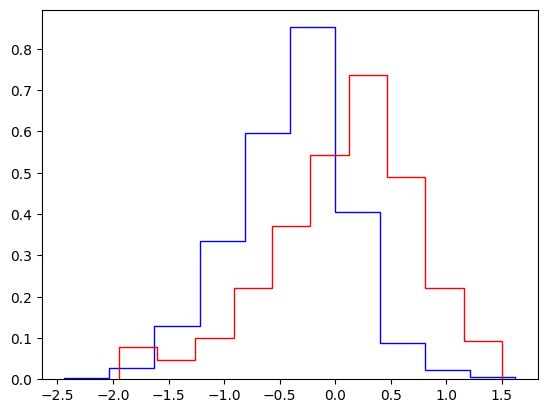

In [20]:
plt.hist(pred_df['I_VS_LB_PRED'], color='blue', density=True, histtype='step')
plt.hist(y_train, color='red', density=True, histtype='step')

In [21]:
pred_df.sort_values('I_VS_LB_PRED', ascending=False).head(50)

,FILM_ID,FILM_TITLE,FILM_WATCH_COUNT,FILM_TOP_250,FILM_IS_TOP_250,FILM_RATING,LIKES_PER_WATCH,FANS_PER_WATCH,FILM_RUNTIME,FILM_YEAR,...,Jack Angel,Alan Tudyk,Channing Tatum,Thomas Rosales Jr.,Mickie McGowan,Sherry Lynn,FILM_RATING_SCALED,I_VS_LB,I_VS_LB_PRED,FILM_RATING_PRED
17202,f_0r4bK,The Fight Machine,150,266.00,0,0.00,0.13,0.00,104.00,2022,...,0.00,0.00,0.00,0.00,0.00,0.00,NaN,NaN,1.62,2.35
12690,f_09oig,Soul Searcher,16,266.00,0,0.00,0.12,0.00,98.00,2005,...,0.00,0.00,0.00,0.00,0.00,0.00,NaN,NaN,1.59,2.33
12808,f_01ojC,Sting of the Black Scorpion,171,266.00,0,0.00,0.16,0.00,84.00,2002,...,0.00,0.00,0.00,0.00,0.00,0.00,NaN,NaN,1.54,2.29
4438,f_05XqQ,Space Monster DEMEKING,90,266.00,0,0.00,0.17,0.00,99.00,2009,...,0.00,0.00,0.00,0.00,0.00,0.00,NaN,NaN,1.44,2.21
10423,f_0hbTY,Thom Pain,86,266.00,0,0.00,0.13,0.01,74.00,2017,...,0.00,0.00,0.00,0.00,0.00,0.00,NaN,NaN,1.40,2.18
5960,f_038RM,The Saint Meets the Tiger,195,266.00,0,0.00,0.14,0.00,69.00,1941,...,0.00,0.00,0.00,0.00,0.00,0.00,NaN,NaN,1.38,2.16
7545,f_0cQXM,Sherlock Gnomes,58165,266.00,0,2.18,0.07,0.00,86.00,2018,...,0.00,0.00,0.00,0.00,0.00,0.00,NaN,NaN,1.38,3.88
6684,f_06lQS,Exploding Sun,148,266.00,0,0.00,0.11,0.00,174.00,2013,...,0.00,0.00,0.00,0.00,0.00,0.00,NaN,NaN,1.37,2.16
14708,f_04Or4,Scent of Mystery,276,266.00,0,0.00,0.13,0.00,125.00,1960,...,0.00,0.00,0.00,0.00,0.00,0.00,NaN,NaN,1.36,2.15
5714,f_0aX7k,400 Days,3821,266.00,0,2.19,0.06,0.00,91.00,2015,...,0.00,0.00,0.00,0.00,0.00,0.00,NaN,NaN,1.36,3.88


In [22]:
final_df = pd.concat([pred_df, rated_features], axis=0).reset_index(drop=True)
print('Calculating SHAP values...')
if model_type == 'xgboost' or model_type == 'decision_tree':
    explainer = shap.TreeExplainer(model, X_train)
elif model_type == 'linear_regression':
    explainer = shap.LinearExplainer(model, X_train)
# shap_values = explainer.Explainer(X_pred)
shap_values = explainer.shap_values(X_pred)
explainer_df = pd.DataFrame(shap_values, columns=model_features)
explainer_df.insert(0, 'FILM_ID', pred_df['FILM_ID'])

Calculating SHAP values...


100%|===================| 17780/17810 [00:43<00:00]        

In [30]:
explainer2 = shap.TreeExplainer(model, feature_names=model_features)
explanation = explainer2(X_pred)
shap_values2 = explainer2.shap_values(X_pred)

In [31]:
X_pred.shape

(17810, 131)

In [32]:
shap.initjs()
shap.force_plot(explainer2.expected_value, shap_values2[0, :], X_pred[0])

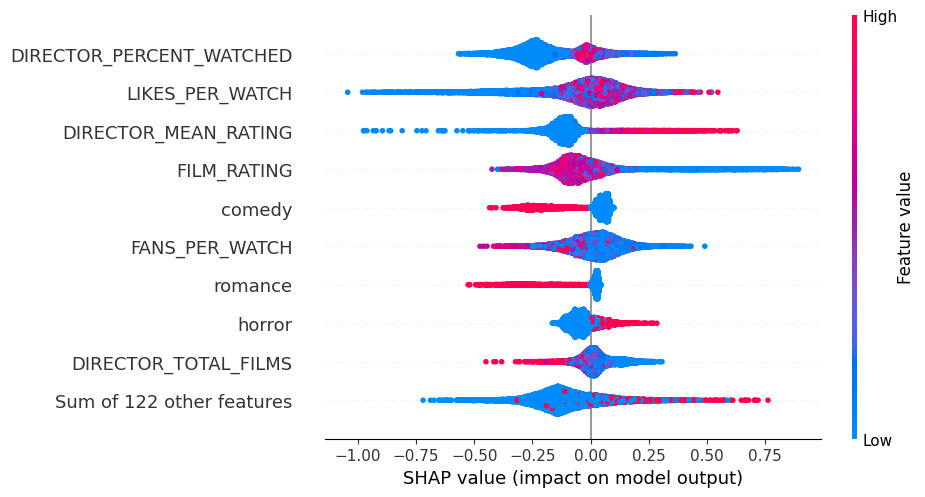

In [33]:
shap.plots.beeswarm(explanation)

In [34]:
tmp_film_id = 'f_0J1hQ'
tmp = explainer_df[explainer_df['FILM_ID']==tmp_film_id].drop('FILM_ID', axis=1)
tmp2 = tmp.loc[:, (abs(tmp) > 0.01).any(axis=0)].T.reset_index()
tmp2.columns = ['col_name', 'col_shap']
tmp3 = unrated_features[unrated_features['FILM_ID']==tmp_film_id].T.reset_index()
tmp3.columns = ['col_name', 'col_val']
tmp4 = tmp3.merge(tmp2, how='inner', on='col_name')
tmp4.sort_values('col_shap')

,col_name,col_val,col_shap
5,DIRECTOR_PERCENT_WATCHED,0.00,-0.32
0,FILM_RATING,3.22,-0.11
3,DIRECTOR_MEAN_RATING,2.81,-0.07
7,comedy,1,-0.06
2,FANS_PER_WATCH,0.00,-0.03
14,thriller,0,-0.02
8,drama,0,-0.02
6,action,0,-0.02
9,fantasy,0,-0.02
11,mystery,0,-0.02


In [36]:
# explainer_df.columns = [x+'_SHAP' if x != 'FILM_ID' else x for x in explainer_df.columns]
explainer_df

,FILM_ID,FILM_IS_TOP_250,FILM_RATING,LIKES_PER_WATCH,FANS_PER_WATCH,DIRECTOR_MEAN_RATING,DIRECTOR_TOTAL_FILMS,DIRECTOR_PERCENT_WATCHED,action,adventure,...,Stan Lee,John Ratzenberger,Jamie Lee Curtis,Vin Diesel,Frank Welker,Chris Evans,Idris Elba,Channing Tatum,Thomas Rosales Jr.,Sherry Lynn
0,f_0t4EQ,0.00,-0.02,-0.12,-0.11,-0.08,0.08,-0.15,-0.05,-0.00,...,0.00,-0.00,0.00,0.00,0.00,-0.00,0.00,-0.00,-0.01,0.00
1,f_02aNK,-0.02,0.26,-0.29,-0.13,-0.03,0.02,-0.02,-0.02,-0.00,...,0.00,-0.00,0.00,0.00,0.00,-0.00,0.00,0.00,-0.00,0.00
2,f_02aNq,-0.02,0.25,-0.13,-0.05,-0.04,0.04,-0.02,-0.02,-0.00,...,0.00,-0.00,0.00,0.00,0.00,-0.00,0.00,0.00,-0.00,0.00
3,f_02axi,-0.02,0.18,-0.24,-0.04,-0.05,0.01,-0.03,0.05,-0.01,...,0.00,-0.00,0.00,0.00,0.00,-0.00,0.00,0.00,-0.00,0.00
4,f_02aq2,-0.00,0.29,-0.09,0.02,0.29,-0.01,-0.02,-0.02,0.00,...,0.00,-0.00,0.00,0.00,0.00,-0.00,0.00,0.00,-0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17805,f_0dS4G,-0.00,-0.10,0.16,0.34,-0.06,-0.00,-0.21,-0.02,-0.01,...,0.00,-0.00,0.00,0.00,0.00,-0.00,0.00,0.00,-0.00,0.00
17806,f_0fqnk,-0.00,-0.12,0.14,0.06,-0.05,0.02,-0.19,0.08,-0.01,...,0.00,-0.00,0.00,0.00,0.00,-0.00,0.00,0.00,-0.01,0.00
17807,f_0ncTC,-0.00,-0.07,-0.01,0.03,-0.09,0.05,-0.23,0.09,0.02,...,0.00,-0.00,0.00,0.00,0.00,-0.00,0.00,-0.00,-0.00,0.00
17808,f_0iOxY,-0.00,-0.08,0.06,0.17,-0.08,-0.00,-0.16,0.06,-0.01,...,0.00,-0.00,0.00,0.00,0.00,-0.00,0.00,0.00,-0.00,0.00


In [37]:
pred_df

,FILM_ID,FILM_TITLE,FILM_WATCH_COUNT,FILM_TOP_250,FILM_IS_TOP_250,FILM_RATING,LIKES_PER_WATCH,FANS_PER_WATCH,FILM_RUNTIME,FILM_YEAR,...,Jack Angel,Alan Tudyk,Channing Tatum,Thomas Rosales Jr.,Mickie McGowan,Sherry Lynn,FILM_RATING_SCALED,I_VS_LB,I_VS_LB_PRED,FILM_RATING_PRED
0,f_0t4EQ,Death to 2020,87818,266.00,0,2.72,0.11,0.00,71.00,2020,...,0.00,0.00,0.00,0.00,0.00,0.00,NaN,NaN,-0.85,2.55
1,f_02aNK,The Godfather,2601138,12.00,1,4.54,0.40,0.03,175.00,1972,...,0.00,0.00,0.00,0.00,0.00,0.00,NaN,NaN,-0.52,4.25
2,f_02aNq,The Godfather Part II,1388181,6.00,1,4.59,0.36,0.03,202.00,1974,...,0.00,0.00,0.00,0.00,0.00,0.00,NaN,NaN,-0.33,4.44
3,f_02axi,Seven Samurai,457951,4.00,1,4.61,0.40,0.03,207.00,1954,...,0.00,0.00,0.00,0.00,0.00,0.00,NaN,NaN,-0.13,4.61
4,f_02aq2,Schindler's List,1557920,13.00,1,4.53,0.31,0.01,195.00,1993,...,0.00,0.00,0.00,0.00,0.00,0.00,NaN,NaN,0.42,4.98
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17805,f_0dS4G,Diamond Island,1688,266.00,0,3.46,0.19,0.00,101.00,2016,...,0.00,0.00,0.00,0.00,0.00,0.00,NaN,NaN,0.04,3.83
17806,f_0fqnk,The King,3637,266.00,0,3.36,0.12,0.00,134.00,2017,...,0.00,0.00,0.00,0.00,0.00,0.00,NaN,NaN,-0.20,3.57
17807,f_0ncTC,Alienoid: Return to the Future,4782,266.00,0,3.21,0.19,0.00,122.00,2024,...,0.00,0.00,0.00,0.00,0.00,0.00,NaN,NaN,-0.19,3.45
17808,f_0iOxY,Believer,8822,266.00,0,3.33,0.17,0.00,123.00,2018,...,0.00,0.00,0.00,0.00,0.00,0.00,NaN,NaN,-0.07,3.65


In [38]:
def visualise_shap_for_feature(feature_name):
    if feature_name in [x for x in explainer_df.columns if x != 'FILM_ID']:
        values = pred_df[feature_name]
        shaps = explainer_df[feature_name]
        plt.scatter(x=values, y=shaps)
    else:
        print('Choose a Feature Used in the model')

In [39]:
[x for x in explainer_df.columns if x != 'FILM_ID']

['FILM_IS_TOP_250',
 'FILM_RATING',
 'LIKES_PER_WATCH',
 'FANS_PER_WATCH',
 'DIRECTOR_MEAN_RATING',
 'DIRECTOR_TOTAL_FILMS',
 'DIRECTOR_PERCENT_WATCHED',
 'action',
 'adventure',
 'animation',
 'comedy',
 'crime',
 'drama',
 'family',
 'fantasy',
 'history',
 'horror',
 'music',
 'mystery',
 'none',
 'romance',
 'science-fiction',
 'thriller',
 'war',
 'aftercreditsstinger',
 'aggressive',
 'alien life-form',
 'amused',
 'android',
 'anthropomorphism',
 'anti hero',
 'anxious',
 'army',
 'artificial intelligence (a.i.)',
 'astronaut',
 'based on comic',
 'body horror',
 'brutality',
 'church',
 'corpse',
 'creature',
 'cult',
 'cyberpunk',
 'cyborg',
 'death game',
 'decapitation',
 'demon',
 'demonic possession',
 'dramatic',
 'duringcreditsstinger',
 'dystopia',
 'evil',
 'exorcism',
 'female protagonist',
 'folk horror',
 'frightened',
 'future',
 'good versus evil',
 'gore',
 'gothic',
 'grief',
 'halloween',
 'hallucination',
 'haunted house',
 'horrified',
 'insanity',
 'intense'

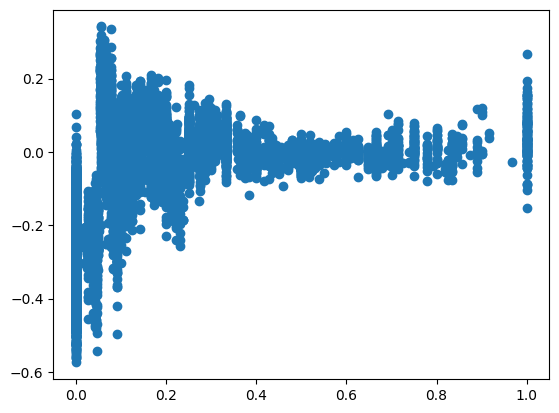

In [41]:
visualise_shap_for_feature('DIRECTOR_PERCENT_WATCHED')

ValueError: x and y must be the same size

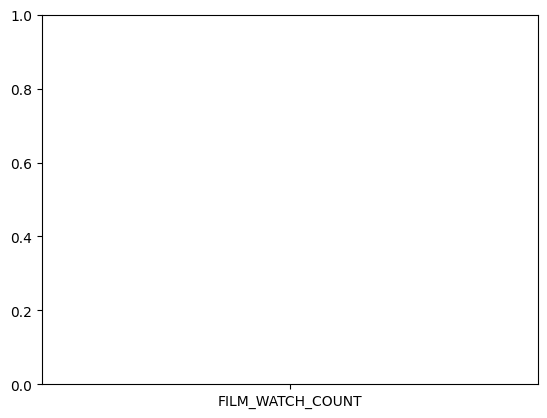

In [43]:
plt.scatter(data=explainer_df, x='FILM_WATCH_COUNT', y='DIRECTOR_PERCENT_WATCHED')

In [44]:
pred_df.sort_values('FILM_RATING_PRED')

,FILM_ID,FILM_TITLE,FILM_WATCH_COUNT,FILM_TOP_250,FILM_IS_TOP_250,FILM_RATING,LIKES_PER_WATCH,FANS_PER_WATCH,FILM_RUNTIME,FILM_YEAR,...,Jack Angel,Alan Tudyk,Channing Tatum,Thomas Rosales Jr.,Mickie McGowan,Sherry Lynn,FILM_RATING_SCALED,I_VS_LB,I_VS_LB_PRED,FILM_RATING_PRED
17696,f_02Paa,Broadway Rhythm,156,266.00,0,0.00,0.13,0.00,115.00,1944,...,0.00,0.00,0.00,0.00,0.00,0.00,NaN,NaN,-1.36,0.00
13208,f_01dqs,Living It Up,244,266.00,0,0.00,0.07,0.00,112.00,2000,...,0.00,0.00,0.00,0.00,0.00,0.00,NaN,NaN,-1.12,0.19
17198,f_034W4,Dead Awake,190,266.00,0,0.00,0.23,0.01,100.00,2001,...,0.00,0.00,0.00,0.00,0.00,0.00,NaN,NaN,-0.99,0.29
16253,f_01lCQ,Death in Love,219,266.00,0,0.00,0.05,0.00,97.00,2008,...,0.00,0.00,0.00,0.00,0.00,0.00,NaN,NaN,-0.95,0.32
17292,f_02P50,Mack the Knife,186,266.00,0,0.00,0.16,0.00,118.00,1989,...,0.00,0.00,0.00,0.00,0.00,0.00,NaN,NaN,-0.95,0.32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4084,f_01dJa,The Human Condition II: Road to Eternity,26335,37.00,1,4.43,0.38,0.00,178.00,1959,...,0.00,0.00,0.00,0.00,0.00,0.00,NaN,NaN,0.26,4.77
344,f_04E5i,Prisoners,1889642,143.00,1,4.30,0.37,0.02,153.00,2013,...,0.00,0.00,0.00,0.00,0.00,0.00,NaN,NaN,0.50,4.87
17502,f_00Msm,Incendies,408632,44.00,1,4.42,0.38,0.03,131.00,2010,...,0.00,0.00,0.00,0.00,0.00,0.00,NaN,NaN,0.46,4.92
4,f_02aq2,Schindler's List,1557920,13.00,1,4.53,0.31,0.01,195.00,1993,...,0.00,0.00,0.00,0.00,0.00,0.00,NaN,NaN,0.42,4.98


In [45]:
ex

NameError: name 'ex' is not defined

In [39]:

# import ipdb; ipdb.set_trace()
try:
    ex = explainer.expected_value[0]
except:
    ex = explainer.expected_value
explainer_df.insert(1, 'BASE_VALUE', ex)
explainer_df['PREDICTION'] = explainer_df.sum(axis=1)
explainer_df = explainer_df.merge(pred_df[['FILM_ID', 'ALGO_SCORE']], how='left', on='FILM_ID')
explainer_df['SCALER'] = explainer_df['ALGO_SCORE'] / explainer_df['PREDICTION']
explainer_df = explainer_df.drop('FILM_ID', axis=1).mul(explainer_df['SCALER'], axis=0).drop(['ALGO_SCORE', 'SCALER'], axis=1) 
explainer_df.insert(0, 'FILM_ID', pred_df['FILM_ID'])
explainer_df = explainer_df.loc[:, (explainer_df != 0).any(axis=0)]
print('SHAP values calculated!')

C:\Users\tom\AppData\Local\Temp\ipykernel_60388\1129709933.py:7: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  explainer_df['PREDICTION'] = explainer_df.sum(axis=1)


KeyError: "['ALGO_SCORE'] not in index"

In [235]:
X_train

array([[ 0.93282623,  0.07302188, -0.08215985, ..., -0.09325048,
        -0.10319204, -0.10319204],
       [-0.51551018,  0.07302188, -0.08215985, ..., -0.09325048,
        -0.10319204, -0.10319204],
       [ 0.17525549,  0.07302188, -0.08215985, ..., -0.09325048,
        -0.10319204, -0.10319204],
       ...,
       [-0.61828158,  0.07302188, -0.08215985, ..., -0.09325048,
        -0.10319204, -0.10319204],
       [-0.69483497,  0.07302188, -0.08215985, ..., -0.09325048,
        -0.10319204, -0.10319204],
       [-0.55662786,  0.07302188, -0.08215985, ..., -0.09325048,
        -0.10319204, -0.10319204]])